In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None )
#pd.set_option('display.max_rows', None )
from el_myfuction import *
from ACP_KMEANS_functions import *

In [129]:
data_customers = pd.read_csv('olist_customers_dataset.csv')
data_order_items = pd.read_csv('olist_order_items_dataset.csv')
data_order_payments = pd.read_csv('olist_order_payments_dataset.csv')
data_order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
data_orders = pd.read_csv('olist_orders_dataset.csv')
data_products = pd.read_csv('olist_products_dataset.csv')
data_trad = pd.read_csv('product_category_name_translation.csv')
data_geoloc = pd.read_csv('olist_geolocation_dataset.csv')

# constitution fichier client

In [309]:
#produit sans categorie on met unknow
data_products['product_category_name'].fillna(value='unknown',inplace=True)

In [310]:
liste_client = data_customers['customer_unique_id'].unique()

In [311]:
data_commande = pd.DataFrame(liste_client, index=liste_client )
data_commande.columns = ['customer_unique_id']

In [312]:
data_commande = data_commande.merge(data_customers, on = 'customer_unique_id', how='left')

In [313]:
data_commande.drop(['customer_city', 'customer_state','customer_id'], inplace=True, axis=1)

In [314]:
data_commande.columns=['customer_unique_id', 'geolocation_zip_code_prefix']

In [315]:
data_geoloc_mean = data_geoloc.groupby(by = 'geolocation_zip_code_prefix').mean()

In [316]:
data_commande = data_commande.merge(data_geoloc_mean, on = 'geolocation_zip_code_prefix', how='left',)

In [317]:
data_commande.drop(['geolocation_zip_code_prefix'], inplace=True, axis=1)

In [318]:
data_orders['delai_livraison'] = pd.to_datetime(data_orders['order_delivered_customer_date'])-pd.to_datetime(data_orders['order_purchase_timestamp'])

In [319]:
def categorie_produit(produit):
    '''
    Input : product_id
    Output : categorie
    '''
    main_categ='unknown'
    main_categ_en='unknown'
    category = data_products.loc[(data_products['product_id']==produit), ['product_category_name']]
    if len(category)>0:
        main_categ = category.value_counts().index[0][0]
        main_categ_en = data_trad.loc[data_trad.product_category_name==main_categ,'product_category_name_english']
        if len(main_categ_en)>0:
            main_categ_en = main_categ_en.values[0]
        else:
            main_categ_en=main_categ
    return main_categ_en
    

def calcul_RF(client):
    '''
    retourne la date de la dernière commande pour un numero de client unique
    '''
    # on retrouve tous les numeros de client à partir du numéro client unique
    filter_client = data_customers['customer_unique_id']==client 
    num_client = data_customers.loc[ filter_client, 'customer_id']
    
    # on retrouve toutes les commandes
    commandes = data_orders.loc[(data_orders['customer_id'].isin(num_client)), ['order_purchase_timestamp', 'order_id','delai_livraison']]
    liste_commande  = commandes['order_id'].to_list()
    nb_commande = len(liste_commande)
    
    # on recherche tous les produits pour avoir le prix payé et le nombre de paiement
    items = data_order_items.loc[(data_order_items['order_id'].isin(liste_commande)), ['price', 'freight_value', 'product_id']]
    total_price = items['price'].sum()
    total_freight = items['freight_value'].sum()
    
    # on recherche tous les paiements pour controle 
    payments = data_order_payments.loc[(data_order_payments['order_id'].isin(liste_commande)), ['payment_value', 'payment_installments']]
    total_pay = payments['payment_value'].sum() 
    nb_pay = payments['payment_installments'].sum() 

    # on recherche tous les produits pour avoir les notes et categorie du produit le plus cher
    review = data_order_reviews.loc[(data_order_reviews['order_id'].isin(liste_commande)), ['review_score']].mean()
    main_categ_count_en='unknown'
    main_categ_price_en='unknown'
    if len(items)>0:
        produit_count = items[['price','product_id']].groupby(by='product_id').size().sort_values(ascending=False).index[0]
        main_categ_count_en = categorie_produit(produit_count)
        
        produit = items.sort_values(by='price', ascending=False).iloc[0,2]
        main_categ_price_en = categorie_produit(produit)
    
    # on recupere la date de la derniere commande
    date = commandes['order_purchase_timestamp'].sort_values(ascending=False)
    delai = commandes['delai_livraison'].mean()
    
    return pd.Series([total_price/nb_commande, total_freight/nb_commande, total_pay/nb_commande, nb_pay/nb_commande,
                      nb_commande, pd.to_datetime(date.to_list()[0]), review[0], delai, main_categ_count_en, main_categ_price_en])

calcul_RF('a7d4cb9ba936ebc0eb30b73c5d3a62d8')
calcul_RF('8d50f5eadf50201ccdcedfb9e2ac8455')


0                    42.918824
1                    10.142353
2                    54.566471
3                     1.352941
4                           17
5          2018-08-20 19:14:26
6                     4.764706
7    4 days 00:55:02.333333333
8     fashion_bags_accessories
9               sports_leisure
dtype: object

In [321]:
data_commande[['prix_par_commande', 'livraison_par_commande', 'paye_par_commande',
               'nb_paye_par_commande', 'nb_commande', 'date_derniere_commande',
               'note_par_commande', 'delai', 'main_categ_count_en', 'main_categ_price_en']] = data_commande['customer_unique_id'].apply(calcul_RF)

In [322]:
data_commande.describe()

,geolocation_lat,geolocation_lng,prix_par_commande,livraison_par_commande,paye_par_commande,nb_paye_par_commande,nb_commande,note_par_commande,delai
count,99163.000000,99163.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,99441.000000,96681
mean,-21.191224,-46.175442,136.680481,22.645685,160.988648,2.980893,1.079223,4.071286,12 days 13:23:06.077200277
std,5.608637,4.056067,208.796682,21.440373,220.699205,2.718493,0.396154,1.346586,9 days 11:19:03.654440816
min,-33.689948,-72.668881,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0 days 12:48:07
25%,-23.589378,-48.097950,45.900000,13.750000,62.770000,1.000000,1.000000,4.000000,6 days 19:27:02.500000
50%,-22.924970,-46.630647,86.250000,17.170000,106.070000,2.000000,1.000000,5.000000,10 days 06:14:00
75%,-20.139828,-43.598897,149.900000,24.090000,176.990000,4.000000,1.000000,5.000000,15 days 16:30:16
max,42.184003,-8.723762,13440.000000,1794.960000,13664.080000,29.000000,17.000000,5.000000,209 days 15:05:12


In [325]:
data_commande

,customer_unique_id,geolocation_lat,geolocation_lng,prix_par_commande,livraison_par_commande,paye_par_commande,nb_paye_par_commande,nb_commande,date_derniere_commande,note_par_commande,delai,main_categ_count_en,main_categ_price_en
0,861eff4711a542e4b93843c6dd7febb0,-20.498489,-47.396929,124.99,21.88,146.87,2.0,1,2017-05-16 15:05:35,4.0,8 days 19:30:00,office_furniture,office_furniture
1,290c77bc529b7ac935b93aa66c333dc3,-23.727992,-46.542848,289.00,46.48,335.48,8.0,1,2018-01-12 20:48:24,5.0,16 days 15:52:55,housewares,housewares
2,060e732b5b29e8181a18229c7b0b2b5e,-23.531642,-46.656289,139.94,17.79,157.73,7.0,1,2018-05-19 16:07:45,5.0,26 days 01:51:06,office_furniture,office_furniture
3,259dac757896d24d7702b9acbbff3f3c,-23.499702,-46.185233,149.94,23.36,173.30,1.0,1,2018-03-13 16:06:38,5.0,14 days 23:57:47,office_furniture,office_furniture
4,345ecd01c38d18a9036ed96c73b8d066,-22.975100,-47.142925,230.00,22.25,252.25,8.0,1,2018-07-29 09:51:30,5.0,11 days 11:04:18,home_confort,home_confort
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,1a29b476fee25c95fbafc67c5ac95cf8,-23.586003,-46.499638,74.90,13.88,88.78,6.0,1,2018-04-07 15:48:17,4.0,6 days 04:18:20,books_general_interest,books_general_interest
99437,d52a67c98be1cf6a5c84435bd38d095d,-23.615830,-46.768533,114.90,14.16,129.06,3.0,1,2018-04-04 08:20:22,5.0,7 days 10:34:23,sports_leisure,sports_leisure
99438,e9f50caf99f032f0bf3c55141f019d99,-3.734569,-38.510534,37.00,19.04,56.04,5.0,1,2018-04-08 20:11:50,1.0,30 days 22:51:25,health_beauty,health_beauty
99439,73c2643a0a458b49f58cea58833b192e,-29.949839,-51.168494,689.00,22.07,711.07,2.0,1,2017-11-03 21:08:33,5.0,12 days 22:50:06,watches_gifts,watches_gifts


In [326]:
data_commande.set_index('customer_unique_id')

,geolocation_lat,geolocation_lng,prix_par_commande,livraison_par_commande,paye_par_commande,nb_paye_par_commande,nb_commande,date_derniere_commande,note_par_commande,delai,main_categ_count_en,main_categ_price_en
customer_unique_id,,,,,,,,,,,,
861eff4711a542e4b93843c6dd7febb0,-20.498489,-47.396929,124.99,21.88,146.87,2.0,1,2017-05-16 15:05:35,4.0,8 days 19:30:00,office_furniture,office_furniture
290c77bc529b7ac935b93aa66c333dc3,-23.727992,-46.542848,289.00,46.48,335.48,8.0,1,2018-01-12 20:48:24,5.0,16 days 15:52:55,housewares,housewares
060e732b5b29e8181a18229c7b0b2b5e,-23.531642,-46.656289,139.94,17.79,157.73,7.0,1,2018-05-19 16:07:45,5.0,26 days 01:51:06,office_furniture,office_furniture
259dac757896d24d7702b9acbbff3f3c,-23.499702,-46.185233,149.94,23.36,173.30,1.0,1,2018-03-13 16:06:38,5.0,14 days 23:57:47,office_furniture,office_furniture
345ecd01c38d18a9036ed96c73b8d066,-22.975100,-47.142925,230.00,22.25,252.25,8.0,1,2018-07-29 09:51:30,5.0,11 days 11:04:18,home_confort,home_confort
...,...,...,...,...,...,...,...,...,...,...,...,...
1a29b476fee25c95fbafc67c5ac95cf8,-23.586003,-46.499638,74.90,13.88,88.78,6.0,1,2018-04-07 15:48:17,4.0,6 days 04:18:20,books_general_interest,books_general_interest
d52a67c98be1cf6a5c84435bd38d095d,-23.615830,-46.768533,114.90,14.16,129.06,3.0,1,2018-04-04 08:20:22,5.0,7 days 10:34:23,sports_leisure,sports_leisure
e9f50caf99f032f0bf3c55141f019d99,-3.734569,-38.510534,37.00,19.04,56.04,5.0,1,2018-04-08 20:11:50,1.0,30 days 22:51:25,health_beauty,health_beauty


In [327]:
data_commande.to_csv('data_commande.csv')

In [328]:
data_commande = pd.read_csv('data_commande.csv',index_col=0)

In [329]:
%store data_commande

Stored 'data_commande' (DataFrame)


In [330]:
data_commande.date_derniere_commande=pd.to_datetime(data_commande.date_derniere_commande)
data_commande.delai=pd.to_timedelta(data_commande.delai)

In [331]:
def date_heure(datetime):
    '''
    Input : datetime64
    Output : [date, heure]
    '''
    date = pd.to_datetime(datetime.date())
    data_num = date.value
    heure = datetime.time()
    heure_num = heure.hour * 3600 + heure.minute * 60 + heure.second
    return pd.Series([data_num, heure_num])
    
data_commande[['date_commande', 'heure_commande']] = data_commande['date_derniere_commande'].apply(date_heure)

In [332]:
#data_commande[['date_commande', 'heure_commande']] = data_commande['date_derniere_commande'].apply(date_heure)
data_commande[['delai_seconds']] = data_commande['delai'].apply(lambda x: pd.to_timedelta(x).total_seconds())

In [333]:
data_commande.drop(['customer_unique_id'], axis=1, inplace=True)

In [334]:
data_commande.date_commande = data_commande.date_commande/3600/24/1000000000

In [335]:
data_commande.to_csv('data_commande_dateNumerique.csv')

In [4]:
data_commande = pd.read_csv('data_commande_dateNumerique.csv',index_col=0)

In [5]:
data_commande.date_derniere_commande = pd.to_datetime(data_commande.date_derniere_commande )
data_commande.delai = pd.to_timedelta(data_commande.delai )

In [6]:
data_commande.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   geolocation_lat         99163 non-null  float64        
 1   geolocation_lng         99163 non-null  float64        
 2   prix_par_commande       99441 non-null  float64        
 3   livraison_par_commande  99441 non-null  float64        
 4   paye_par_commande       99441 non-null  float64        
 5   nb_paye_par_commande    99441 non-null  float64        
 6   nb_commande             99441 non-null  int64          
 7   date_derniere_commande  99441 non-null  datetime64[ns] 
 8   note_par_commande       99441 non-null  float64        
 9   delai                   96681 non-null  timedelta64[ns]
 10  main_categ_count_en     99441 non-null  object         
 11  main_categ_price_en     99441 non-null  object         
 12  date_commande           99441 no

In [7]:
data_commande

,geolocation_lat,geolocation_lng,prix_par_commande,livraison_par_commande,paye_par_commande,nb_paye_par_commande,nb_commande,date_derniere_commande,note_par_commande,delai,main_categ_count_en,main_categ_price_en,date_commande,heure_commande,delai_seconds
0,-20.498489,-47.396929,124.99,21.88,146.87,2.0,1,2017-05-16 15:05:35,4.0,8 days 19:30:00,office_furniture,office_furniture,17302.0,54335,761400.0
1,-23.727992,-46.542848,289.00,46.48,335.48,8.0,1,2018-01-12 20:48:24,5.0,16 days 15:52:55,housewares,housewares,17543.0,74904,1439575.0
2,-23.531642,-46.656289,139.94,17.79,157.73,7.0,1,2018-05-19 16:07:45,5.0,26 days 01:51:06,office_furniture,office_furniture,17670.0,58065,2253066.0
3,-23.499702,-46.185233,149.94,23.36,173.30,1.0,1,2018-03-13 16:06:38,5.0,14 days 23:57:47,office_furniture,office_furniture,17603.0,57998,1295867.0
4,-22.975100,-47.142925,230.00,22.25,252.25,8.0,1,2018-07-29 09:51:30,5.0,11 days 11:04:18,home_confort,home_confort,17741.0,35490,990258.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,-23.586003,-46.499638,74.90,13.88,88.78,6.0,1,2018-04-07 15:48:17,4.0,6 days 04:18:20,books_general_interest,books_general_interest,17628.0,56897,533900.0
99437,-23.615830,-46.768533,114.90,14.16,129.06,3.0,1,2018-04-04 08:20:22,5.0,7 days 10:34:23,sports_leisure,sports_leisure,17625.0,30022,642863.0
99438,-3.734569,-38.510534,37.00,19.04,56.04,5.0,1,2018-04-08 20:11:50,1.0,30 days 22:51:25,health_beauty,health_beauty,17629.0,72710,2674285.0
99439,-29.949839,-51.168494,689.00,22.07,711.07,2.0,1,2017-11-03 21:08:33,5.0,12 days 22:50:06,watches_gifts,watches_gifts,17473.0,76113,1119006.0


In [8]:
data_commande.note_par_commande = np.round(data_commande.note_par_commande).astype(int)

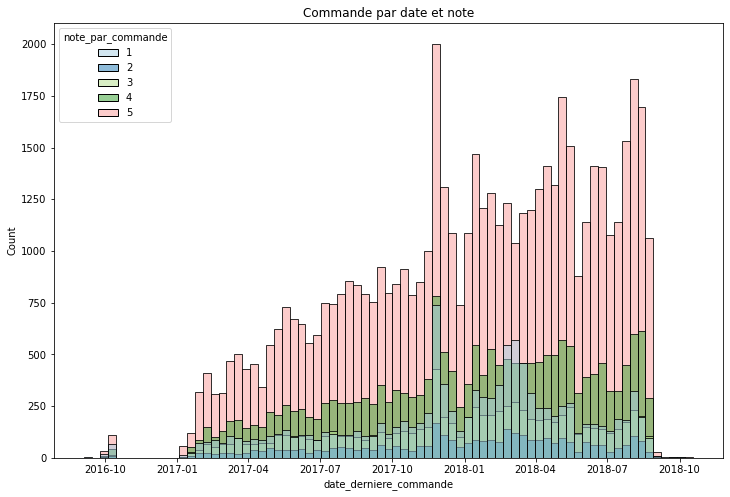

In [12]:
plt.figure(figsize=(12, 8))
sns.histplot(x='date_derniere_commande', hue ='note_par_commande', data= data_commande, palette='Paired')
plt.title('Commande par date et note')
plt.savefig('P1-01_date_note.jpg')
plt.show()

In [13]:
data_commande.nb_paye_par_commande = np.round(data_commande.nb_paye_par_commande).astype(int)

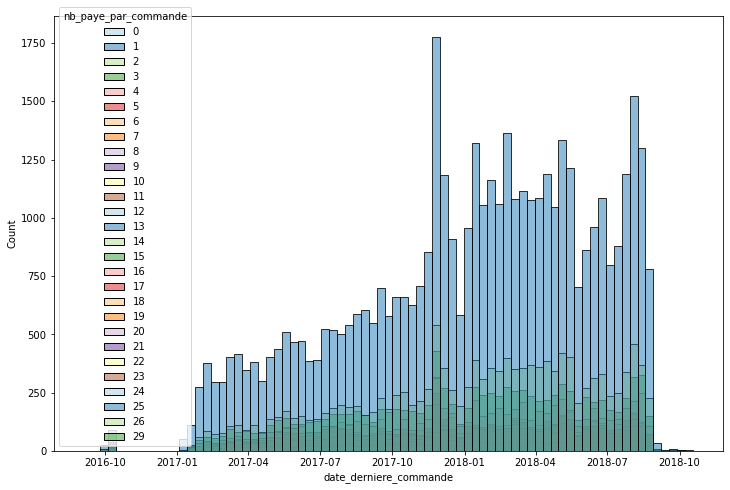

In [409]:
plt.figure(figsize=(12, 8))
sns.histplot(x='date_derniere_commande', hue ='nb_paye_par_commande', data= data_commande, palette='Paired')
plt.show()

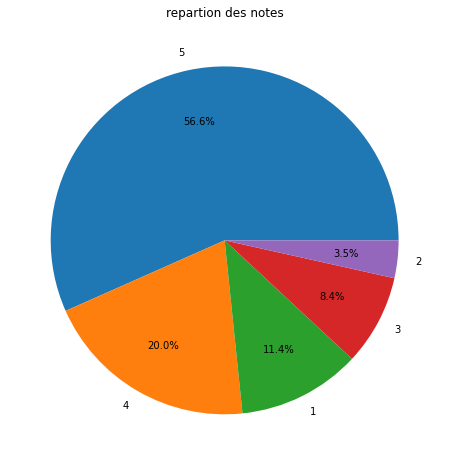

In [15]:
note_pie = data_commande.note_par_commande.value_counts()

plt.figure(figsize=(12, 8))
plt.pie(note_pie, labels= note_pie.index, autopct='%1.1f%%', pctdistance=0.7)
plt.title('repartion des notes')
plt.savefig('P1-02_repartition_note.jpg')
plt.show() 

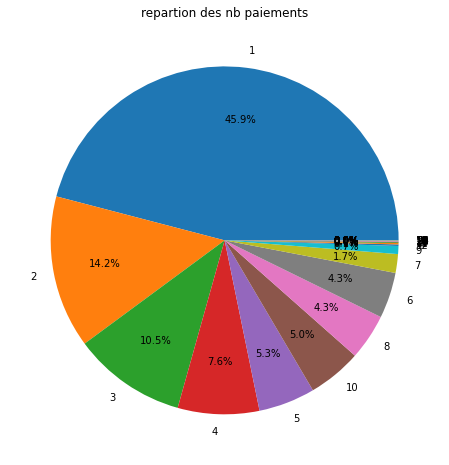

In [16]:
note_pie = data_commande.nb_paye_par_commande.value_counts()

plt.figure(figsize=(12, 8))
plt.pie(note_pie, labels= note_pie.index, autopct='%1.1f%%', pctdistance=0.7)
plt.title('repartion des nb paiements')
plt.savefig('P1-03_repartition_nb_paiements.jpg')
plt.show() 

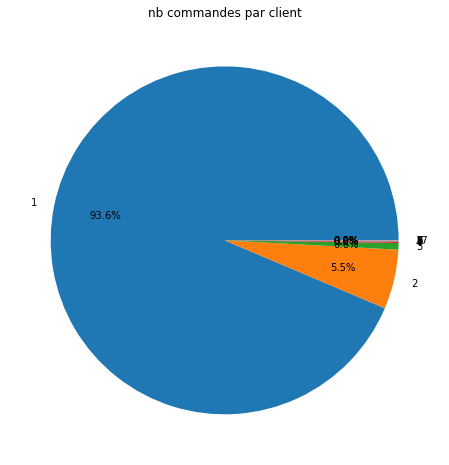

In [9]:
note_pie = data_commande.nb_commande.value_counts()

plt.figure(figsize=(12, 8))
plt.pie(note_pie, labels= note_pie.index, autopct='%1.1f%%', pctdistance=0.7)
plt.title('nb commandes par client')
plt.savefig('P1-04_repartition_nb_commande.jpg')
plt.show() 

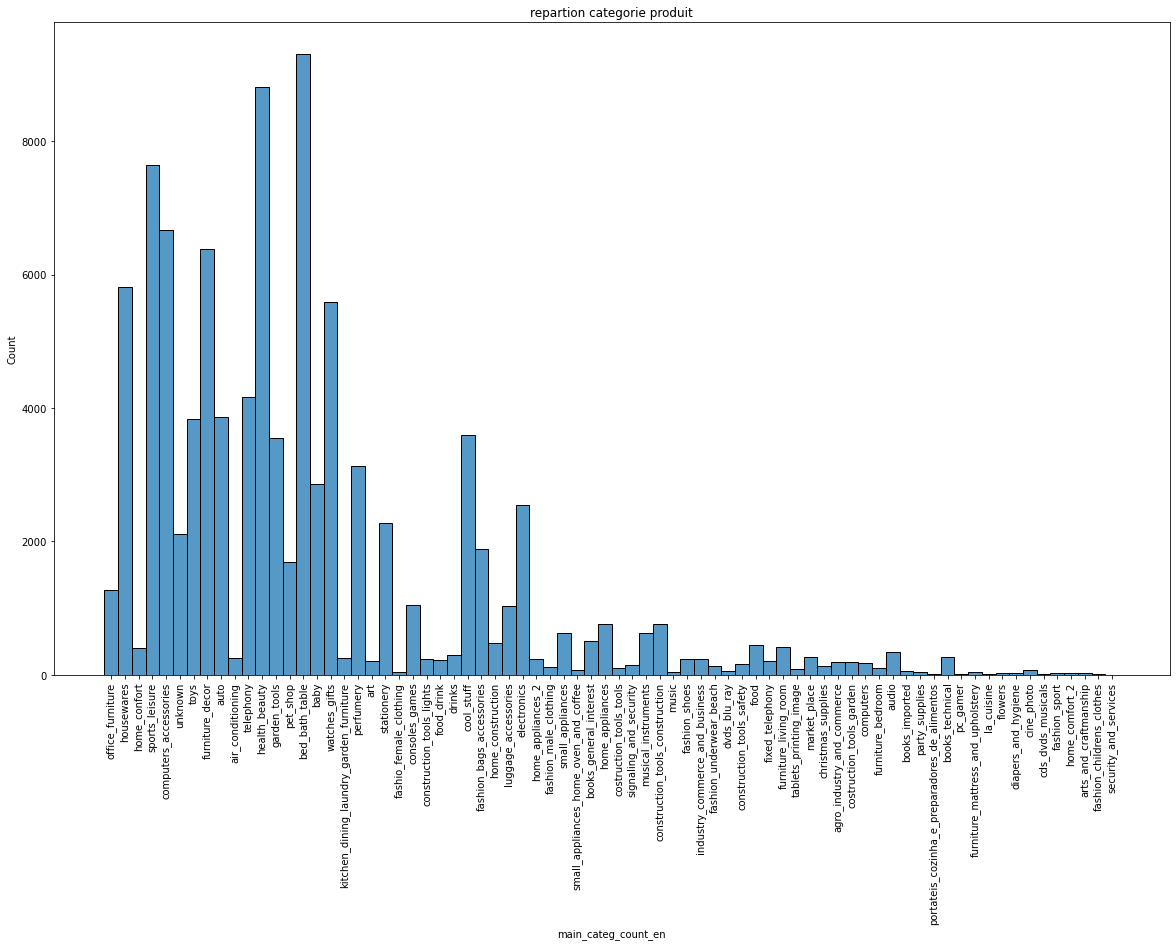

In [18]:
plt.figure(figsize=(20, 12))
sns.histplot(x='main_categ_count_en', data= data_commande, palette='Paired')
plt.xticks(rotation=90)
plt.title('repartion categorie produit')
plt.savefig('P1-05_repartition_categorie.jpg')
plt.show()

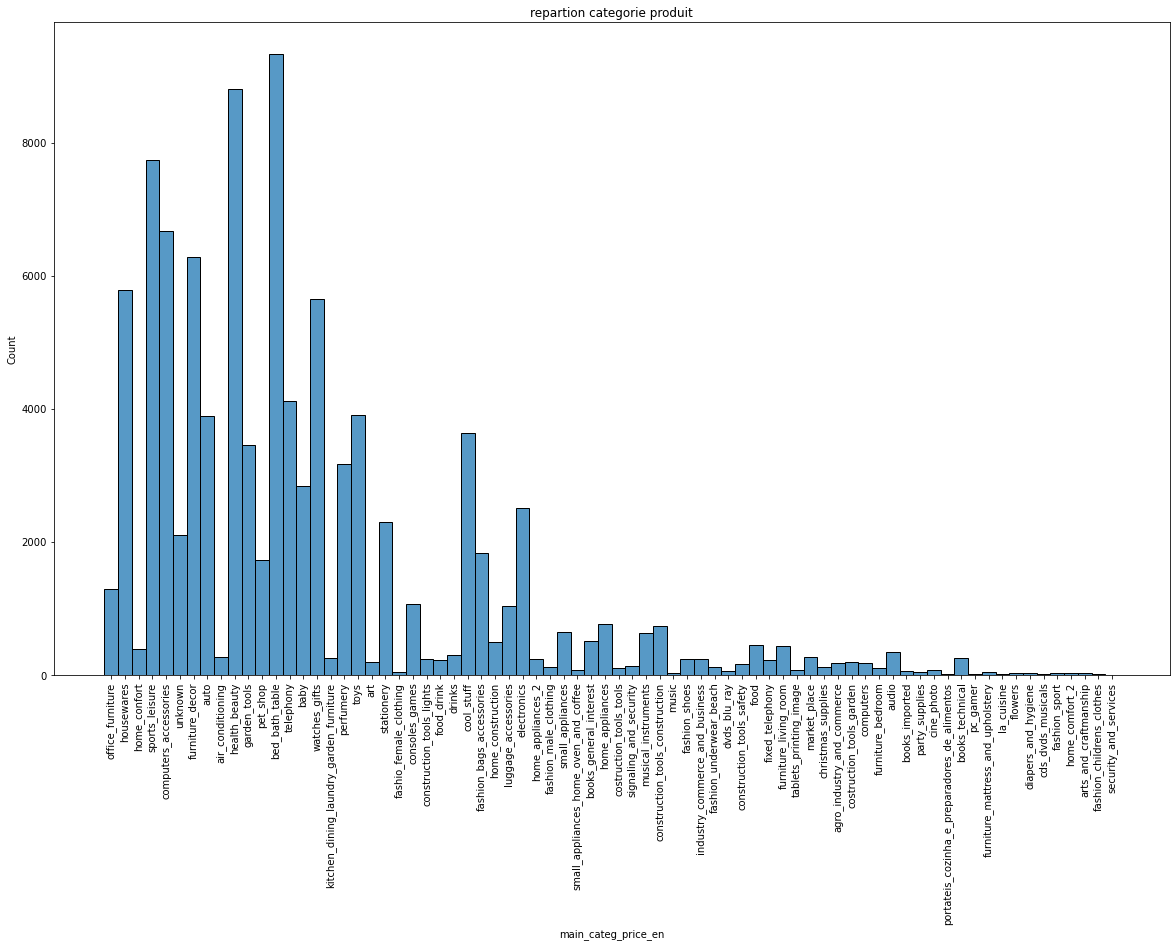

In [19]:
plt.figure(figsize=(20, 12))
sns.histplot(x='main_categ_price_en', data= data_commande, palette='Paired')
plt.xticks(rotation=90)
plt.title('repartion categorie produit')
plt.savefig('P1-06_repartition_categorie_price.jpg')
plt.show()

In [415]:
data_commande.main_categ_count_en.value_counts().head(20)

bed_bath_table              9313
health_beauty               8817
sports_leisure              7649
computers_accessories       6674
furniture_decor             6388
housewares                  5817
watches_gifts               5591
telephony                   4170
auto                        3869
toys                        3838
cool_stuff                  3599
garden_tools                3546
perfumery                   3134
baby                        2858
electronics                 2544
stationery                  2280
unknown                     2116
fashion_bags_accessories    1878
pet_shop                    1690
office_furniture            1264
Name: main_categ_count_en, dtype: int64

In [416]:
data_commande.main_categ_price_en.value_counts().head(20)

bed_bath_table              9340
health_beauty               8799
sports_leisure              7741
computers_accessories       6667
furniture_decor             6285
housewares                  5779
watches_gifts               5646
telephony                   4115
toys                        3905
auto                        3885
cool_stuff                  3633
garden_tools                3458
perfumery                   3166
baby                        2836
electronics                 2502
stationery                  2303
unknown                     2095
fashion_bags_accessories    1825
pet_shop                    1724
office_furniture            1283
Name: main_categ_price_en, dtype: int64

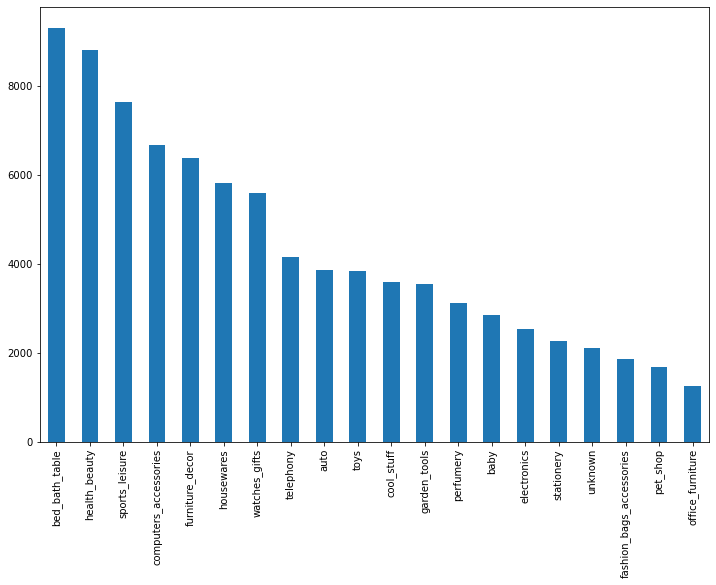

In [417]:
plt.figure(figsize=(12, 8))
data_commande.main_categ_count_en.value_counts().head(20).plot(kind='bar')
plt.show()

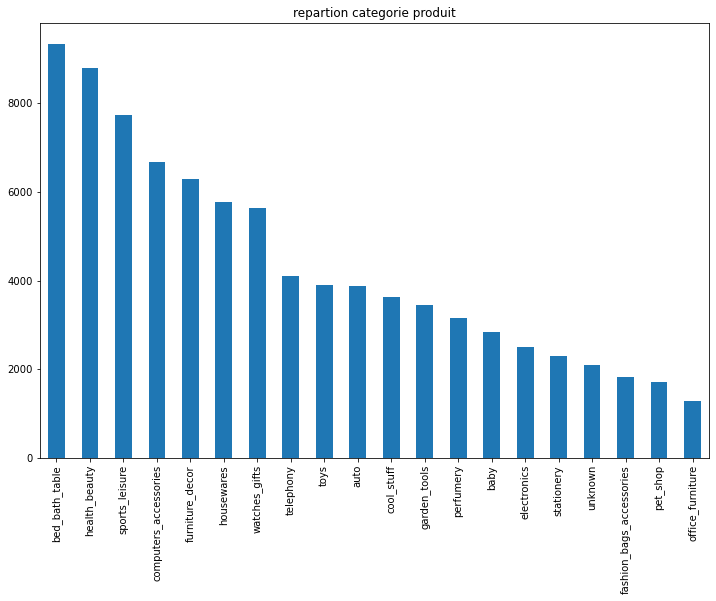

In [20]:
plt.figure(figsize=(12, 8))
data_commande.main_categ_price_en.value_counts().head(20).plot(kind='bar')
plt.title('repartion categorie produit')
plt.savefig('P1-07_repartition_categorie_head.jpg')
plt.show()

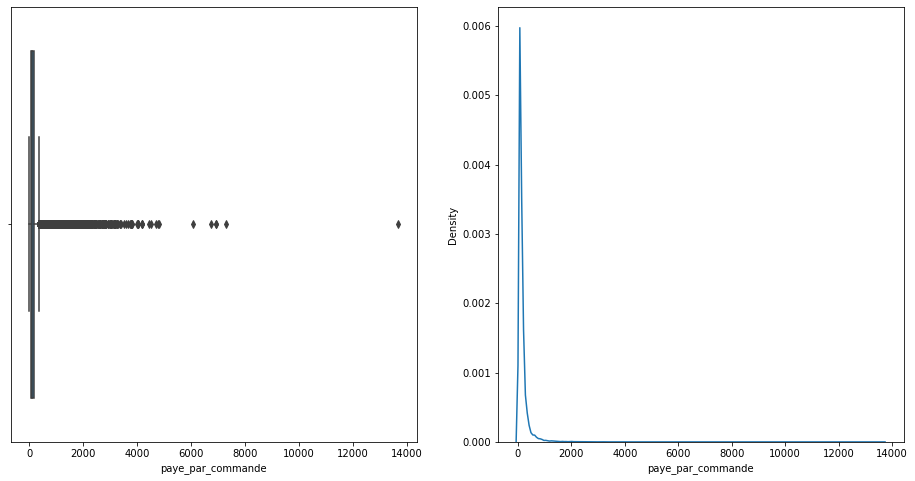

In [419]:
el_kde_box(data_commande.paye_par_commande)

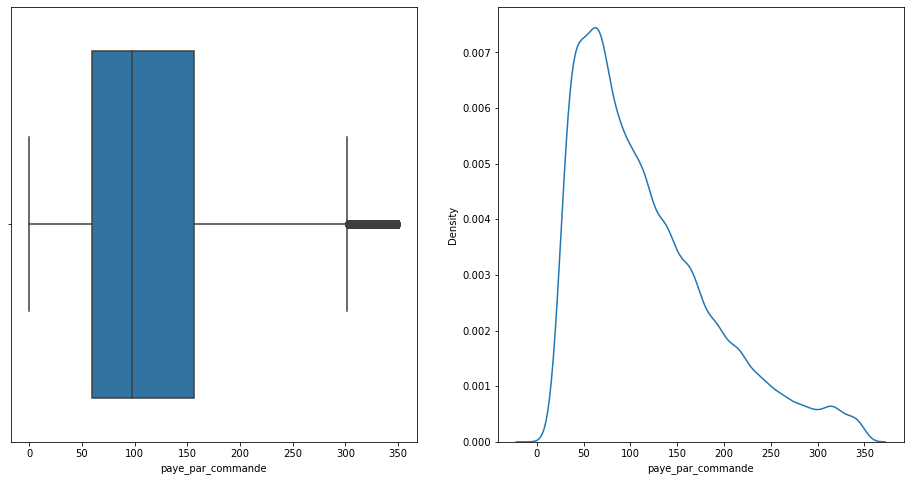

In [420]:
el_kde_box(data_commande.paye_par_commande[data_commande.paye_par_commande<350])

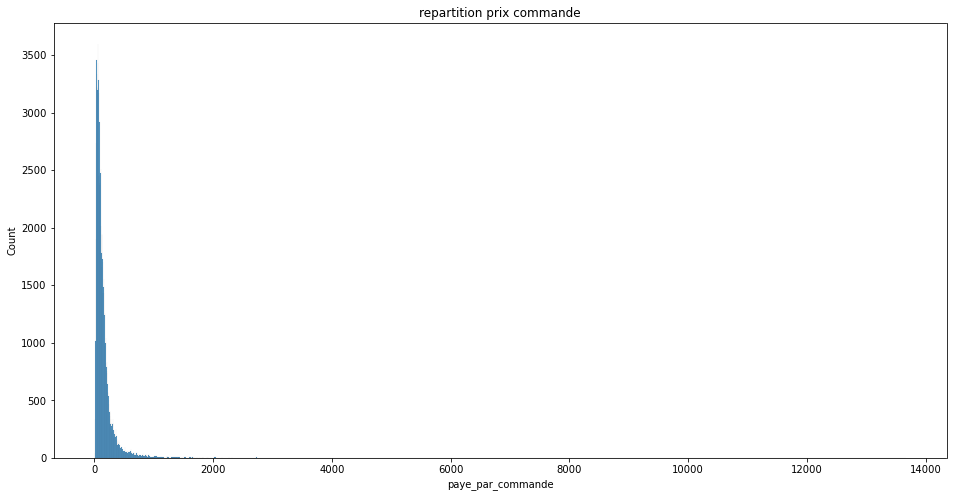

In [12]:
plt.figure(figsize=(16, 8))
plt.title('repartition prix commande')
sns.histplot(x=data_commande.paye_par_commande)
plt.savefig('P1-10_distrib_price0.jpg')
plt.show()


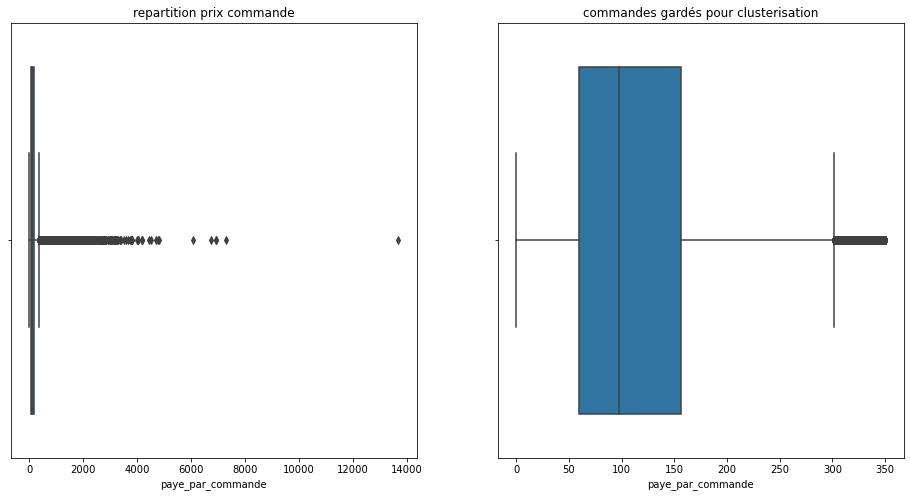

In [44]:
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.title('repartition prix commande')
sns.boxplot(x=data_commande.paye_par_commande)
plt.subplot(1,2,2)
plt.title('repartition prix commande pour prix<350')
sns.boxplot(x=data_commande.paye_par_commande[data_commande.paye_par_commande<350])
plt.title('commandes gardés pour clusterisation')
plt.savefig('P1-10_distrib_price.jpg')
plt.show()


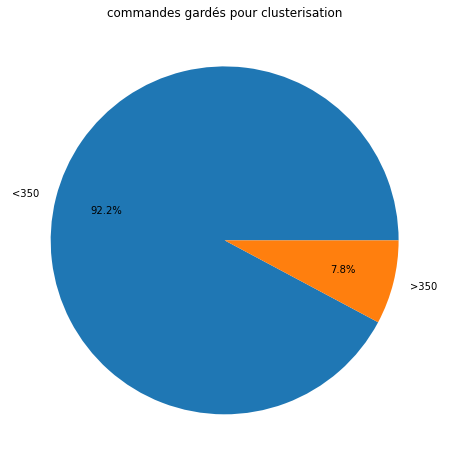

In [40]:
note_pie = (data_commande.paye_par_commande<350).sum()/len(data_commande)

plt.figure(figsize=(12, 8))
plt.pie([note_pie, 1-note_pie], labels=['<350', '>350'], autopct='%1.1f%%', pctdistance=0.7)
plt.title('commandes gardés pour clusterisation')
plt.savefig('P1-08_commande_350.jpg')
plt.show()

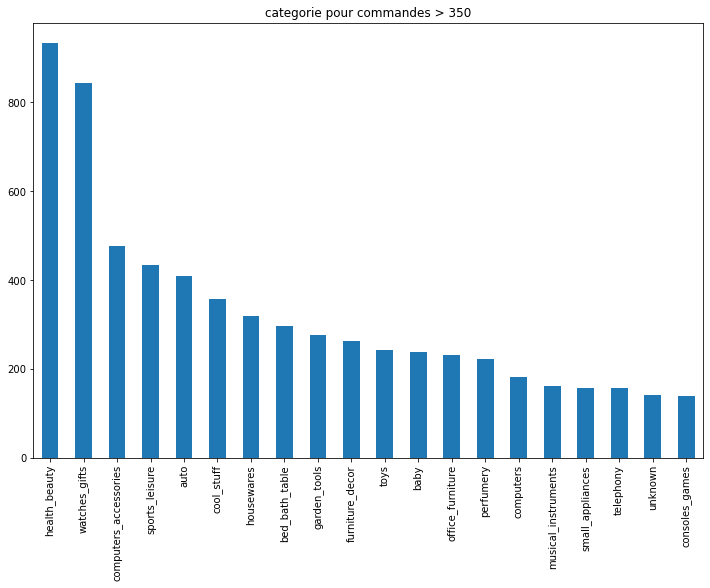

In [41]:
plt.figure(figsize=(12, 8))
data_commande.loc[(data_commande.paye_par_commande>350),'main_categ_price_en'].value_counts().head(20).plot(kind='bar')
plt.title('categorie pour commandes > 350')
plt.savefig('P1-09_categorie_commande_350.jpg')
plt.show()

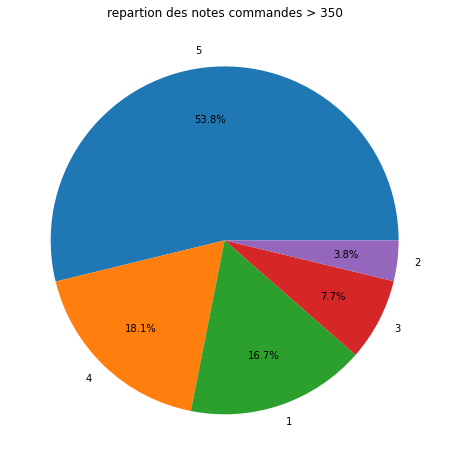

In [422]:
#plus de mecontent 1 dans les grosses commandes
note_pie = data_commande.loc[(data_commande.paye_par_commande>350),'note_par_commande'].value_counts()

plt.figure(figsize=(12, 8))
plt.pie(note_pie, labels= note_pie.index, autopct='%1.1f%%', pctdistance=0.7)
plt.title('repartion des notes commandes > 350')
plt.show() 

In [423]:
data_commande

,geolocation_lat,geolocation_lng,prix_par_commande,livraison_par_commande,paye_par_commande,nb_paye_par_commande,nb_commande,date_derniere_commande,note_par_commande,delai,main_categ_count_en,main_categ_price_en,date_commande,heure_commande,delai_seconds
0,-20.498489,-47.396929,124.99,21.88,146.87,2,1,2017-05-16 15:05:35,4,8 days 19:30:00,office_furniture,office_furniture,17302.0,54335,761400.0
1,-23.727992,-46.542848,289.00,46.48,335.48,8,1,2018-01-12 20:48:24,5,16 days 15:52:55,housewares,housewares,17543.0,74904,1439575.0
2,-23.531642,-46.656289,139.94,17.79,157.73,7,1,2018-05-19 16:07:45,5,26 days 01:51:06,office_furniture,office_furniture,17670.0,58065,2253066.0
3,-23.499702,-46.185233,149.94,23.36,173.30,1,1,2018-03-13 16:06:38,5,14 days 23:57:47,office_furniture,office_furniture,17603.0,57998,1295867.0
4,-22.975100,-47.142925,230.00,22.25,252.25,8,1,2018-07-29 09:51:30,5,11 days 11:04:18,home_confort,home_confort,17741.0,35490,990258.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99436,-23.586003,-46.499638,74.90,13.88,88.78,6,1,2018-04-07 15:48:17,4,6 days 04:18:20,books_general_interest,books_general_interest,17628.0,56897,533900.0
99437,-23.615830,-46.768533,114.90,14.16,129.06,3,1,2018-04-04 08:20:22,5,7 days 10:34:23,sports_leisure,sports_leisure,17625.0,30022,642863.0
99438,-3.734569,-38.510534,37.00,19.04,56.04,5,1,2018-04-08 20:11:50,1,30 days 22:51:25,health_beauty,health_beauty,17629.0,72710,2674285.0
99439,-29.949839,-51.168494,689.00,22.07,711.07,2,1,2017-11-03 21:08:33,5,12 days 22:50:06,watches_gifts,watches_gifts,17473.0,76113,1119006.0


In [42]:
data_commande['delai_jours'] = data_commande.delai_seconds/3600/24

In [43]:
data_commande.drop(['delai_seconds'], axis=1, inplace=True)

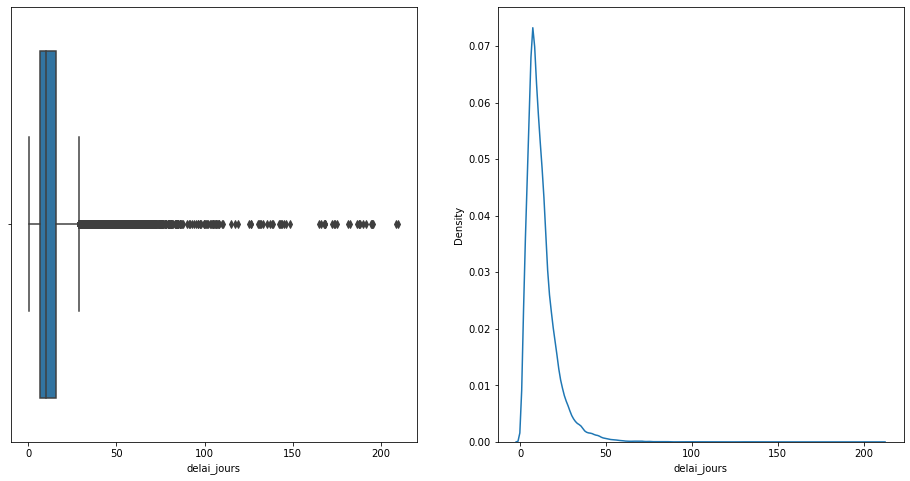

In [426]:
el_kde_box(data_commande.delai_jours)

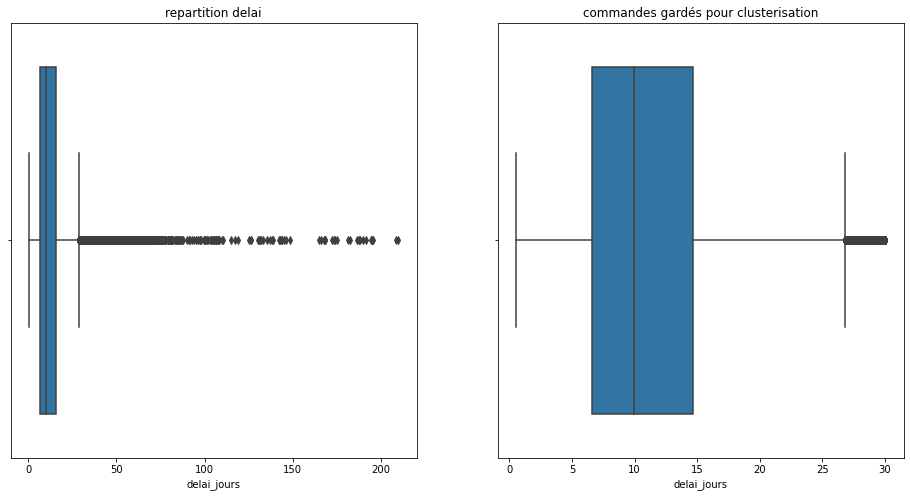

In [46]:
plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.title('repartition delai')
sns.boxplot(x=data_commande.delai_jours)
plt.subplot(1,2,2)
plt.title('repartition delai')
sns.boxplot(x=data_commande.delai_jours[data_commande.delai_jours<30])
plt.title('commandes gardés pour clusterisation')
plt.savefig('P1-11_distrib_delai.jpg')
plt.show()


In [427]:
data_commande.sort_values(by='delai_jours', ascending=False)

,geolocation_lat,geolocation_lng,prix_par_commande,livraison_par_commande,paye_par_commande,nb_paye_par_commande,nb_commande,date_derniere_commande,note_par_commande,delai,main_categ_count_en,main_categ_price_en,date_commande,heure_commande,delai_jours
29212,-18.131133,-40.357112,229.90,15.78,245.68,1,1,2017-02-21 23:31:27,1,209 days 15:05:12,auto,auto,17218.0,84687,209.628611
72053,-22.916897,-43.402789,144.99,17.26,162.25,1,1,2018-02-23 14:57:35,2,208 days 08:26:32,cool_stuff,cool_stuff,17585.0,53855,208.351759
3876,-1.321536,-48.472286,159.90,25.12,185.02,2,1,2017-03-07 23:59:51,1,195 days 15:12:59,consoles_games,consoles_games,17232.0,86391,195.634016
72669,-5.131799,-42.786188,239.96,105.19,345.15,4,1,2017-03-08 18:09:02,4,194 days 20:24:15,office_furniture,office_furniture,17233.0,65342,194.850174
23059,-10.916179,-37.671619,429.90,27.75,457.65,10,1,2017-03-08 22:47:40,1,194 days 15:12:24,musical_instruments,musical_instruments,17233.0,82060,194.633611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99260,-23.596717,-46.483739,13.47,7.39,20.86,1,1,2018-07-17 22:35:46,5,NaT,telephony,telephony,17729.0,81346,NaN
99289,-21.177891,-47.743375,69.90,28.80,98.70,2,1,2018-04-27 13:52:12,5,NaT,furniture_decor,furniture_decor,17648.0,49932,NaN
99297,-22.488555,-44.071911,24.90,14.52,39.42,1,1,2017-02-08 13:07:19,4,NaT,housewares,housewares,17205.0,47239,NaN
99353,-7.197548,-48.198715,526.00,28.96,554.96,8,1,2018-01-25 12:12:37,1,NaT,watches_gifts,watches_gifts,17556.0,43957,NaN


In [428]:
data_commande.to_csv('data_modelisation.csv')

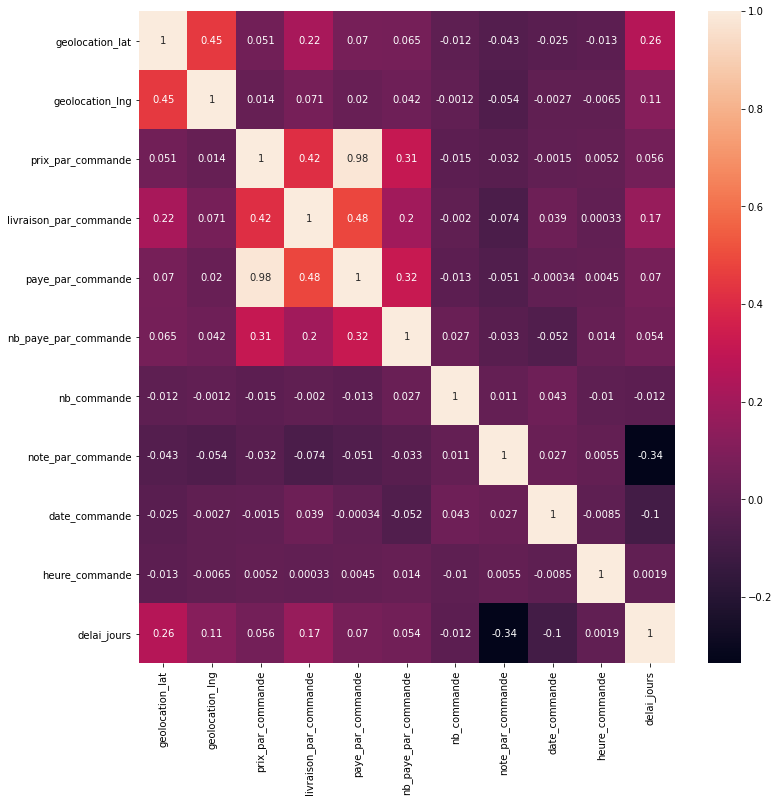

In [429]:
plt.figure(figsize=(12, 12))
sns.heatmap(data_commande.corr(), annot=True)
plt.show()

In [47]:
df_delai=pd.DataFrame(zip(np.round(data_commande.delai_jours),data_commande.note_par_commande), columns=['delai_jours','note_par_commande'])

In [48]:
df_delai

,delai_jours,note_par_commande
0,9.0,4
1,17.0,5
2,26.0,5
3,15.0,5
4,11.0,5
...,...,...
99436,6.0,4
99437,7.0,5
99438,31.0,1
99439,13.0,5


In [49]:
df_delai.delai_jours.value_counts()

7.0      7494
8.0      7194
6.0      6428
9.0      6289
10.0     5886
         ... 
181.0       1
90.0        1
137.0       1
130.0       1
175.0       1
Name: delai_jours, Length: 144, dtype: int64

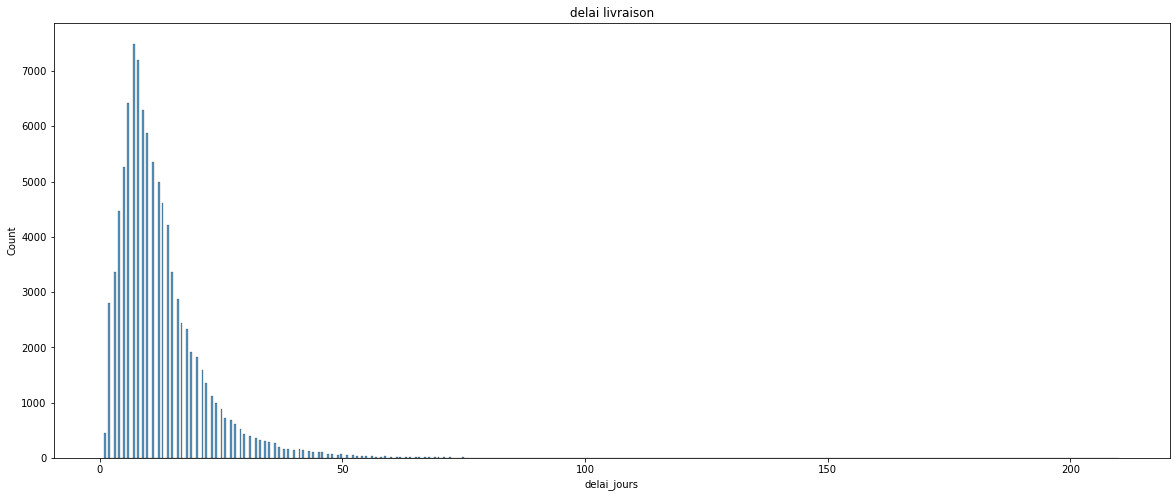

In [51]:
plt.figure(figsize=(20, 8))
sns.histplot(df_delai.delai_jours)
plt.title('delai livraison')
plt.savefig('P1-12_delai.jpg')
plt.show()


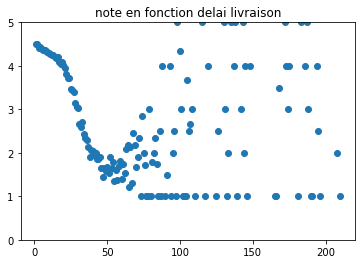

In [52]:
plot_delai = df_delai.groupby(by='delai_jours').mean()
plt.scatter(x=plot_delai.index, y=plot_delai['note_par_commande'])
plt.ylim(0,5)
plt.title('note en fonction delai livraison')
plt.savefig('P1-13_delai_livraison.jpg')
plt.show()


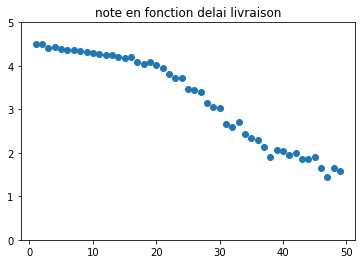

In [54]:
plot_delai = df_delai[df_delai.delai_jours<50].groupby(by='delai_jours').mean()
plt.scatter(x=plot_delai.index, y=plot_delai['note_par_commande'])
plt.title('note en fonction delai livraison')
plt.savefig('P1-14_delai_livraison_50.jpg')
plt.ylim(0,5)
plt.show()


In [3]:
data_commande = pd.read_csv('data_modelisation.csv',index_col=0)

In [4]:
data_commande.date_derniere_commande = pd.to_datetime(data_commande.date_derniere_commande )
data_commande.delai = pd.to_timedelta(data_commande.delai )

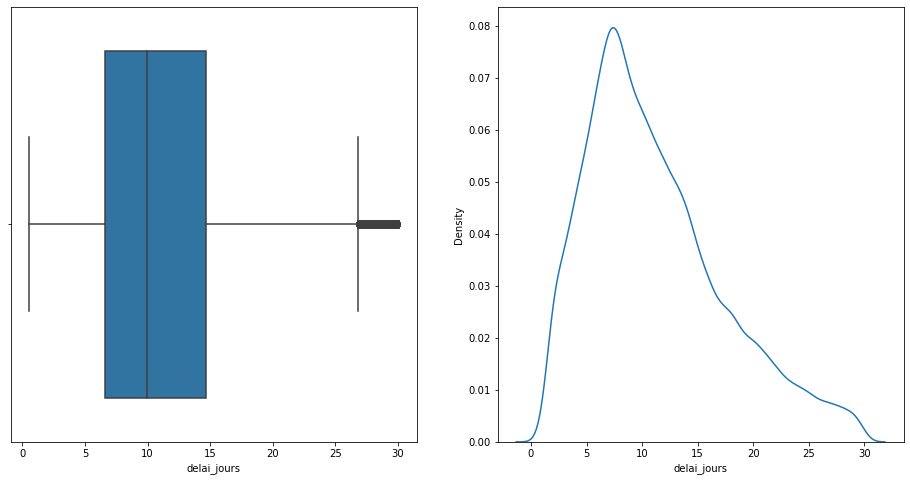

In [437]:
el_kde_box(data_commande.delai_jours[data_commande.delai_jours<30])

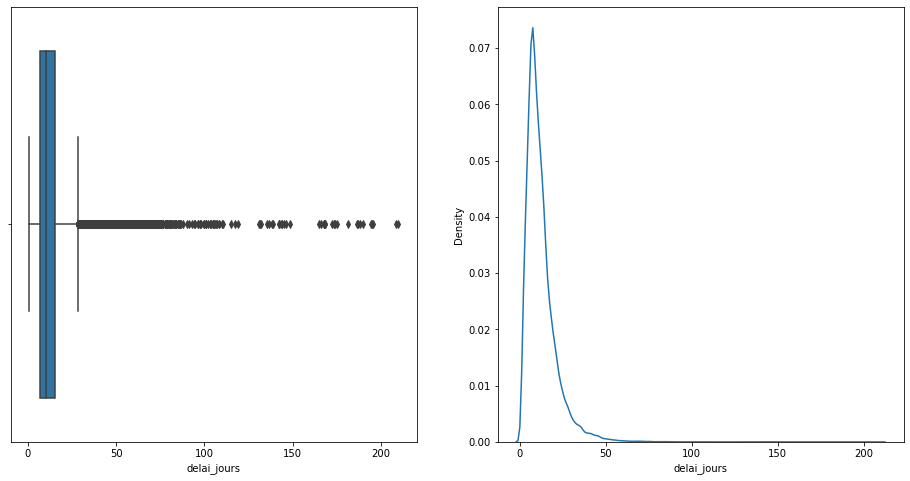

In [438]:
el_kde_box(data_commande.delai_jours[data_commande.paye_par_commande<350])

In [65]:
data_commande[['note_par_commande','delai_jours']].corr()

,note_par_commande,delai_jours
note_par_commande,1.000000,-0.335348
delai_jours,-0.335348,1.000000


In [67]:
data_commande.loc[data_commande.delai_jours<50, ['note_par_commande','delai_jours']].corr()

,note_par_commande,delai_jours
note_par_commande,1.000000,-0.327196
delai_jours,-0.327196,1.000000


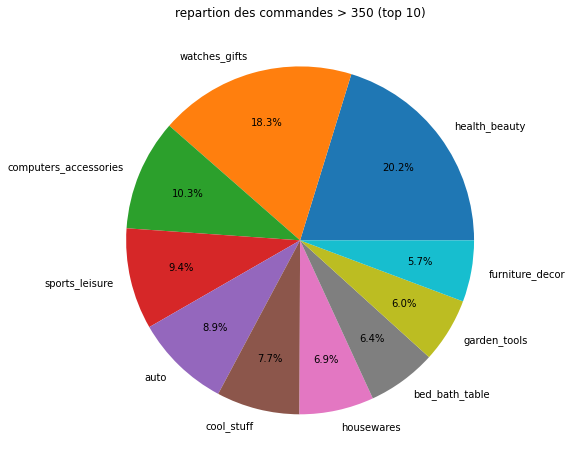

In [17]:
#plus de mecontent 1 dans les grosses commandes
note_pie = data_commande.loc[(data_commande.paye_par_commande>350),'main_categ_price_en'].value_counts().head(10)

plt.figure(figsize=(12, 8))
plt.pie(note_pie, labels= note_pie.index, autopct='%1.1f%%', pctdistance=0.7)
plt.title('repartion des commandes > 350 (top 10)')
plt.show() 

In [12]:
print('categorie pour prix commande > 350')
print(data_commande.loc[(data_commande.paye_par_commande>350),'main_categ_price_en'].value_counts().head(10))


categorie pour prix commande > 350
health_beauty            933
watches_gifts            844
computers_accessories    477
sports_leisure           434
auto                     410
cool_stuff               357
housewares               319
bed_bath_table           296
garden_tools             277
furniture_decor          263
Name: main_categ_price_en, dtype: int64


In [13]:
print('categorie pour delai > 30 j')
print(data_commande.loc[(data_commande.delai_jours>30),'main_categ_price_en'].value_counts().head(10))


categorie pour delai > 30 j
bed_bath_table           429
health_beauty            399
sports_leisure           329
computers_accessories    315
furniture_decor          309
watches_gifts            286
auto                     186
telephony                185
housewares               182
office_furniture         182
Name: main_categ_price_en, dtype: int64


In [68]:
# si commande superieure à 30 jours on a un problème
data_commande.drop(index = data_commande[data_commande.delai_jours>30].index, axis = 0, inplace=True)


In [69]:
# si commande superieure à 350 
data_commande.drop(index = data_commande[data_commande.paye_par_commande>350].index, axis = 0, inplace=True)


In [370]:
data_commande.to_csv('data_modelisation_cut.csv')